In [1]:
# IO
import os

# Data
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import cmcrameri  # nice colormaps

In [2]:
from thesis.io import fgong
from thesis.physics import first_adiabatic_exponent, sound_speed, acoustic_depth
from thesis.calculus import differentiate

In [3]:
# root_path = "/Users/ajl573/OneDrive/Data/MESA/solar_models"
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/")
profile_name = "profile"

In [4]:
Ys = [0.26, 0.28, 0.3]

In [5]:
from cycler import cycler

In [6]:
models = {}
for Y in Ys:
    key = f"y{Y:.2f}"
    filename = os.path.join(root_path, key, ".".join([profile_name, "data", "FGONG"]))
    model = fgong.load_fgong(filename)
    model["cs"] = sound_speed(model.Gamma_1, model.P, model.rho)
    model["tau"] = acoustic_depth(model.r, model.cs, axis=0)
    models[Y] = model

Text(0, 0.5, 'sound speed gradient')

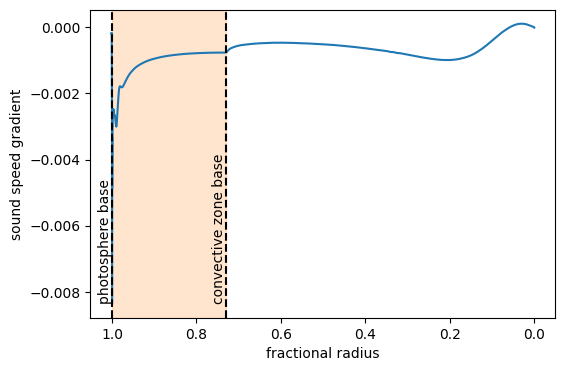

In [197]:
ledoux = model.AA < 0.0
idx_conv, = np.where(ledoux)

fig, ax = plt.subplots(figsize=(6, 4))

y = differentiate(model.cs, model.r)
ymin = y.min()
ax.plot(model.r/model.R, y);

r0 = model.r[0]/model.R
r1 = model.r[idx_conv[0]]/model.R
r2 = model.r[idx_conv[-1]]/model.R

ax.axvline(r1, linestyle="--", c="k")
ax.axvline(r2, linestyle="--", c="k")

kwargs = dict(
    rotation="vertical", verticalalignment="bottom", 
    horizontalalignment="right",
#     bbox=dict(boxstyle='square', fc='white', ec='none'),
)
offset = 0

# ax.text(tau0, ymax, "centre", **kwargs)
ax.text(r1+offset, ymin, "convective zone base", **kwargs)
ax.text(r2+offset, ymin, "photosphere base", **kwargs)

ax.axvspan(r1, r2,
            color="C1", alpha=0.2,
#             hatch="//", facecolor="none", edgecolor="C1", linestyle="none",
           )

# ax.set_xscale("log")
ax.invert_xaxis()

ax.set_xlabel("fractional radius")
ax.set_ylabel("sound speed gradient")

In [220]:
from scipy.interpolate import interp1d

In [223]:
forward = interp1d(model.tau, model.r/model.R, fill_value="extrapolate")
inverse = interp1d(model.r/model.R, model.tau, fill_value="extrapolate")

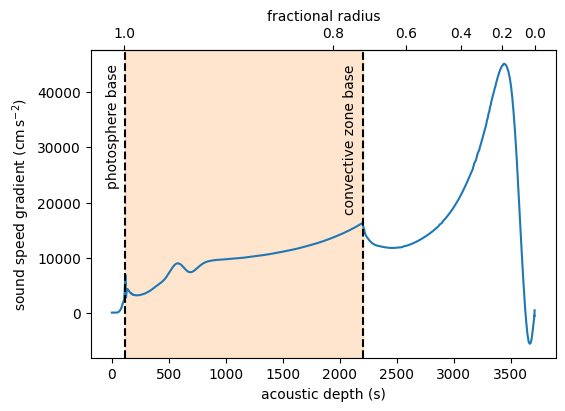

In [226]:
ledoux = model.AA < 0.0
idx_conv, = np.where(ledoux)

fig, ax = plt.subplots(figsize=(6, 4))

y = differentiate(model.cs, model.tau)
ymax = y.max()
ax.plot(model.tau, y);

tau0 = model.tau[0]
tau1 = model.tau[idx_conv[0]]
tau2 = model.tau[idx_conv[-1]]

ax.axvline(tau1, linestyle="--", c="k")
ax.axvline(tau2, linestyle="--", c="k")

kwargs = dict(
    rotation="vertical", verticalalignment="top", 
    horizontalalignment="right",
#     bbox=dict(boxstyle='square', fc='white', ec='none'),
)
offset = -50

# ax.text(tau0, ymax, "centre", **kwargs)
ax.text(tau1+offset, ymax, "convective zone base", **kwargs)
ax.text(tau2+offset, ymax, "photosphere base", **kwargs)

ax.axvspan(tau1, tau2,
            color="C1", alpha=0.2,
#             hatch="//", facecolor="none", edgecolor="C1", linestyle="none",
           )

ax.set_xlabel("acoustic depth (s)")
ax.set_ylabel(r"sound speed gradient ($\mathrm{cm\,s^{-2}}$)")

ax = ax.secondary_xaxis("top", functions=(forward, inverse))
ax.set_xlabel("fractional radius")

fig.savefig("../figures/sound-speed-gradient.pdf", format="PDF", dpi=300, bbox_inches="tight");

In [7]:
custom_cycler = plt.rcParams['axes.prop_cycle'][:4] + cycler(ls=['-', '--', '-.', ':'])

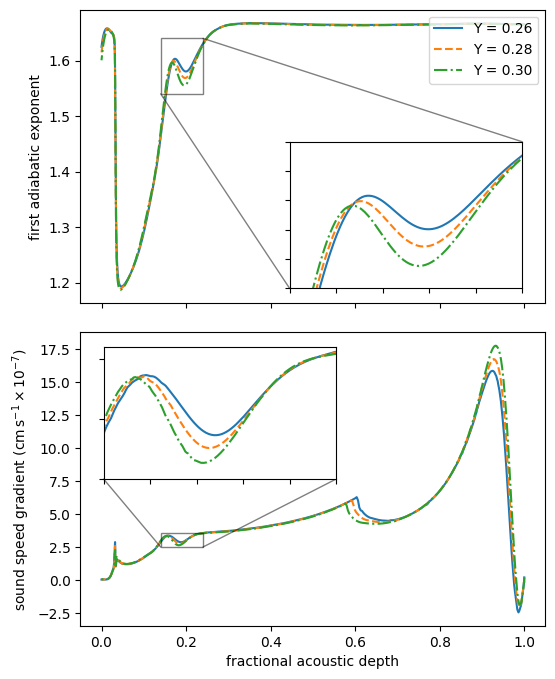

In [227]:
fig, axes = plt.subplots(2, figsize=(6, 8), sharex=True, gridspec_kw={"hspace": 0.1})

# 1

ax = axes[0]
axin = ax.inset_axes([0.45, 0.05, 0.5, 0.5])
xin = (0.14, 0.24)
yin = (1.54, 1.64)

ax.set_prop_cycle(custom_cycler)
axin.set_prop_cycle(custom_cycler)

for Y in Ys:
    tau0 = models[Y].tau.max()
    xy = (models[Y].tau/tau0, models[Y].Gamma_1)
    ax.plot(*xy, label=f"Y = {Y:.2f}")
    axin.plot(*xy)
    
ax.set_ylabel("first adiabatic exponent")
ax.legend(loc='upper right')

axin.set_xlim(xin)
axin.set_ylim(yin)
axin.set_xticklabels([])
axin.set_yticklabels([])

ax.indicate_inset_zoom(axin, edgecolor="black")

# 2

fac = -7

ax = axes[1]
axin = ax.inset_axes([0.05, 0.5, 0.5, 0.45], )
xin = (0.14, 0.24)
yin = (10**fac*2.5e7, 10**fac*3.6e7)

ax.set_prop_cycle(custom_cycler)
axin.set_prop_cycle(custom_cycler)

for Y in Ys:
    tau0 = models[Y].tau.max()
    xy = (models[Y].tau/tau0, 10**fac*tau0*differentiate(models[Y].cs, models[Y].tau))
    ax.plot(*xy, label=f"Y = {Y:.2f}")
    axin.plot(*xy)

ax.set_xlabel("fractional acoustic depth")
ax.set_ylabel(r"sound speed gradient ($\mathrm{cm\,s^{-1}}\times 10^{" + f"{fac}" + "}$)")

axin.set_xlim(xin)
axin.set_ylim(yin)
axin.set_xticklabels([])
axin.set_yticklabels([])

ax.indicate_inset_zoom(axin, edgecolor="black")

fig.savefig("../figures/helium-ionisation-sound-speed.pdf", format="PDF", dpi=300, bbox_inches="tight");

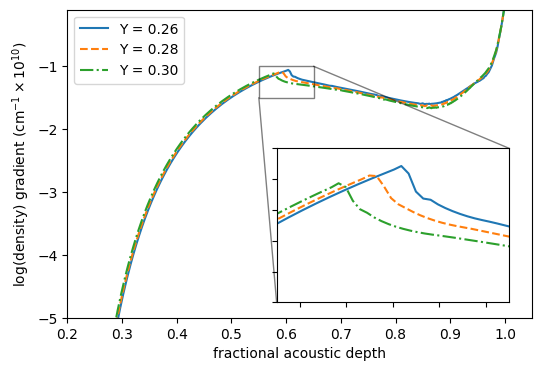

In [228]:
fig, ax = plt.subplots(figsize=(6, 4))

fac = 10
axin = ax.inset_axes([0.45, 0.05, 0.5, 0.5])
xin = (0.55, 0.65)
yin = (-10**fac*1.5e-10, -10**fac*1e-10)

ax.set_prop_cycle(custom_cycler)
axin.set_prop_cycle(custom_cycler)

for Y in Ys:
    tau0 = models[Y].tau.max()
    t = models[Y].tau/tau0
    r = models[Y].r
    y = 10**fac*differentiate(np.log(models[Y].rho), r)
    ax.plot(t, y, label=f"Y = {Y:.2f}")
    axin.plot(t, y)

ax.set_xlim(0.2)
ax.set_ylim(-10**fac*5e-10, -10**fac*1e-11)
ax.set_xlabel("fractional acoustic depth")
ax.set_ylabel(r"log(density) gradient ($\mathrm{cm^{-1}}\times 10^{" + f"{fac}" + "}$)")
ax.legend(loc='upper left')

axin.set_xlim(xin)
axin.set_ylim(yin)
axin.set_xticklabels([])
axin.set_yticklabels([])

ax.indicate_inset_zoom(axin, edgecolor="black")
fig.savefig("../figures/bcz-density-gradient.pdf", format="PDF", dpi=300, bbox_inches="tight")

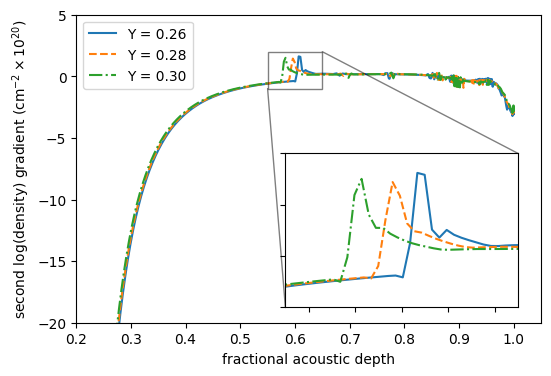

In [113]:
fig, ax = plt.subplots(figsize=(6, 4))

fac = 20
axin = ax.inset_axes([0.45, 0.05, 0.5, 0.5])
xin = (0.55, 0.65)
yin = (-10**fac*1e-20, 10**fac*2e-20)

ax.set_prop_cycle(custom_cycler)
axin.set_prop_cycle(custom_cycler)

for Y in Ys:
    tau0 = models[Y].tau.max()
    t = models[Y].tau/tau0
    r = models[Y].r
    y = 10**fac*differentiate(differentiate(np.log(models[Y].rho), r), r)
    ax.plot(t, y, label=f"Y = {Y:.2f}")
    axin.plot(t, y)

ax.set_xlim(0.2)
ax.set_ylim(-10**fac*2e-19, 10**fac*5e-20)
ax.set_xlabel("fractional acoustic depth")
ax.set_ylabel(r"second log(density) gradient ($\mathrm{cm^{-2}}\times 10^{" + f"{fac}" + "}$)")
ax.legend(loc='upper left')

axin.set_xlim(xin)
axin.set_ylim(yin)
axin.set_xticklabels([])
axin.set_yticklabels([])

ax.indicate_inset_zoom(axin, edgecolor="black");